In [4]:
import os
import numpy as np
from tqdm import tqdm
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras import Model
from keras.callbacks import Callback
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
image_path = '../temp/training/images/'
mask_path = '../temp/training/masks/'
SIZE = 128

In [6]:
# lists of images and masks names
image_names = next(os.walk(image_path))[-1]
mask_names = next(os.walk(mask_path))[-1]

image_names.sort()
mask_names.sort()

images = np.zeros(shape=(len(image_names), SIZE, SIZE, 3))
masks = np.zeros(shape=(len(image_names), SIZE, SIZE, 1))

for id in tqdm(range(len(image_names)), desc="Images"):
    path = image_path + image_names[id]
    img = np.asarray(Image.open(path)).astype("float") / 255.0
    img = cv.resize(img, (SIZE, SIZE), cv.INTER_AREA)
    images[id] = img

for id in tqdm(range(len(mask_names)), desc="Mask"):
    path = mask_path + mask_names[id]
    mask = np.asarray(Image.open(path)).astype("float") / 255.0
    mask = cv.resize(mask, (SIZE, SIZE), cv.INTER_AREA)
    masks[id] = mask[:, :, :1]

Images:   0%|          | 0/4019 [00:00<?, ?it/s]

Mask: 100%|██████████| 4019/4019 [00:09<00:00, 405.36it/s] 


In [7]:
# Train test split
# images_train, images_test, mask_train, mask_test = train_test_split(images, masks, test_size=0.01)

# Train test split with no images left for testing
images_train = images
images_test = []
mask_train = masks
mask_test = []

print(f'Train images: {len(images_train)}')
print(f'Test images: {len(images_test)}')

Train images: 4019
Test images: 0


In [8]:
augmentation_factor = 3

# image augmentation
def get_augmentation_generators():
    # Define parameters for image data generator
    data_gen_args = dict(
        # rotation_range=15,  # Moderate rotation (lakes can be in any orientation)
        # width_shift_range=0.1,  # Small shifts
        # height_shift_range=0.1,
        # zoom_range=0.1,  # Slight zoom in/out
        horizontal_flip=True,  # Lakes can be flipped
        vertical_flip=True,  # Lakes can be flipped
        # fill_mode="reflect",  # Fill with reflected pixels
        # brightness_range=[0.9, 1.1]     # Subtle brightness changes
    )

    # Create image generator for images
    image_datagen = ImageDataGenerator(**data_gen_args)
    # Create image generator for masks with the same seed
    mask_datagen = ImageDataGenerator(**data_gen_args)

    return image_datagen, mask_datagen


def augment_data(images, masks, augmentation_factor):
    """
    Augment the original dataset by the specified factor.
    Returns augmented images and masks.
    """
    image_datagen, mask_datagen = get_augmentation_generators()

    augmented_images = []
    augmented_masks = []

    print(f"Generating {augmentation_factor}x augmented data...")

    for i in tqdm(range(len(images)), desc="Augmenting"):
        # Get original image and mask
        img = images[i]
        mask = masks[i]

        # Add original image and mask to the augmented datasets
        augmented_images.append(img)
        augmented_masks.append(mask)

        # Generate augmentations
        for j in range(augmentation_factor - 1):
            # Set the same seed for both generators to ensure identical transformations
            seed = np.random.randint(1, 1000)

            # Reshape to match ImageDataGenerator expectations (batch dimension needed)
            img_batch = np.expand_dims(img, 0)
            mask_batch = np.expand_dims(mask, 0)

            # Generate augmented image
            img_gen = image_datagen.flow(img_batch, batch_size=1, seed=seed)
            mask_gen = mask_datagen.flow(mask_batch, batch_size=1, seed=seed)

            # Get the augmented image and mask
            aug_img = next(img_gen)[0]  # [0] to extract from batch
            aug_mask = next(mask_gen)[0]

            augmented_images.append(aug_img)
            augmented_masks.append(aug_mask)

    return np.array(augmented_images), np.array(augmented_masks)


# Apply augmentation to training data
augmented_images_train, augmented_masks_train = augment_data(
    images_train, mask_train, augmentation_factor
)

print(f"Original training data size: {len(images_train)}")
print(f"Augmented training data size: {len(augmented_images_train)}")

Generating 3x augmented data...


Augmenting: 100%|██████████| 4019/4019 [00:01<00:00, 2911.38it/s]


Original training data size: 4019
Augmented training data size: 12057


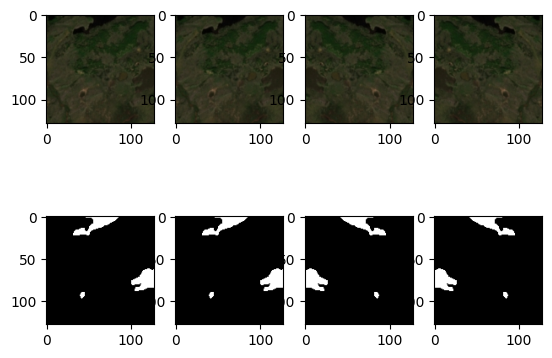

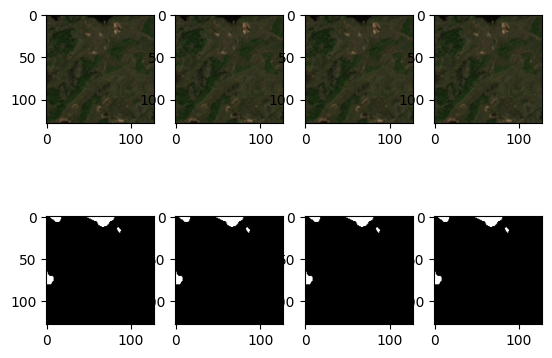

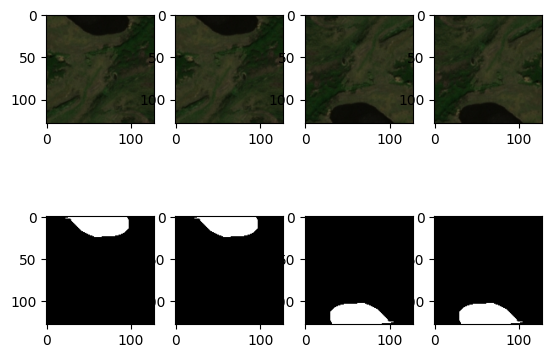

In [9]:
# verify image augmentation is working correctly

for i in range(3):
    img = images_train[i]
    mask = mask_train[i]

    fig, ax = plt.subplots(2, augmentation_factor + 1)
    ax[0][0].imshow(img)
    
    for j in range(augmentation_factor):
        index = i * augmentation_factor + j
        ax[0][j + 1].imshow(augmented_images_train[index])
        ax[1][j + 1].imshow(augmented_masks_train[index], cmap="gray")
    
    ax[1][0].imshow(mask, cmap="gray")

In [10]:
# Define U-net architecture
def unet_model(input_layer, start_neurons):
    # Contraction path
    conv1 = Conv2D(start_neurons, kernel_size=(3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons, kernel_size=(3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons*2, kernel_size=(3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons*2, kernel_size=(3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons*4, kernel_size=(3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons*4, kernel_size=(3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons*8, kernel_size=(3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons*8, kernel_size=(3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons*16, kernel_size=(3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons*16, kernel_size=(3, 3), activation="relu", padding="same")(convm)
    
    # Expansive path
    deconv4 = Conv2DTranspose(start_neurons*8, kernel_size=(3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons*8, kernel_size=(3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons*8, kernel_size=(3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons*4, kernel_size=(3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons*4, kernel_size=(3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons*4, kernel_size=(3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons*2, kernel_size=(3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons*2, kernel_size=(3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons*2, kernel_size=(3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons*1, kernel_size=(3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons, kernel_size=(3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons, kernel_size=(3, 3), activation="relu", padding="same")(uconv1)
    
    # Last conv and output
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [11]:
# Compile unet model
input_layer = Input((SIZE, SIZE, 3))
output_layer = unet_model(input_layer=input_layer, start_neurons=16)

model = Model(input_layer, output_layer)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
# model.summary()

I0000 00:00:1754381245.906962  986381 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9988 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


In [12]:
# Post Process
def mask_threshold(image, threshold=0.25):
    return image > threshold


# Callback to show progress of learning on the images after each epoch
class ShowProgress(Callback):
    def __init__(self, save=False):
        self.save = save

    def on_epoch_end(self, epoch, logs=None):
        k = np.random.randint(len(augmented_images_train))
        original_image = augmented_images_train[k][np.newaxis, ...]
        predicted_mask = self.model.predict(original_image).reshape(128, 128)
        proc_mask02 = mask_threshold(predicted_mask, threshold=0.2)
        proc_mask03 = mask_threshold(predicted_mask, threshold=0.3)
        proc_mask04 = mask_threshold(predicted_mask, threshold=0.4)
        proc_mask05 = mask_threshold(predicted_mask, threshold=0.5)
        mask = augmented_masks_train[k].reshape(128, 128)

        plt.figure(figsize=(15, 10))

        plt.subplot(1, 7, 1)
        plt.imshow(original_image[0])
        plt.title("Orginal Image")

        plt.subplot(1, 7, 2)
        plt.imshow(predicted_mask, cmap="gray")
        plt.title("Predicted Mask")

        plt.subplot(1, 7, 3)
        plt.imshow(mask, cmap="gray")
        plt.title("Orginal Mask")

        plt.subplot(1, 7, 4)
        plt.imshow(proc_mask02, cmap="gray")
        plt.title("Processed: 0.2")

        plt.subplot(1, 7, 5)
        plt.imshow(proc_mask03, cmap="gray")
        plt.title("Processed: 0.3")

        plt.subplot(1, 7, 6)
        plt.imshow(proc_mask04, cmap="gray")
        plt.title("Processed: 0.4")

        plt.subplot(1, 7, 6)
        plt.imshow(proc_mask05, cmap="gray")
        plt.title("Processed: 0.5")

        plt.tight_layout()
        plt.show()

Epoch 1/75


I0000 00:00:1754381251.503621  986536 service.cc:148] XLA service 0x7fc4600378c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754381251.503639  986536 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-08-05 01:07:31.569884: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754381251.887377  986536 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-08-05 01:07:32.380246: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[64,16,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,128,128]{3,2,1,0}, f32[16,3,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_con

  1/189 ━━━━━━━━━━━━━━━━━━━━ 41:08 13s/step - accuracy: 0.6489 - loss: 0.6827

2025-08-05 01:07:42.701277: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_transpose_fusion_1', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1754381262.728696  986536 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7370 - loss: 0.4436

2025-08-05 01:07:56.879399: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[25,16,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,3,128,128]{3,2,1,0}, f32[16,3,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-08-05 01:07:56.886856: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[25,16,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,16,128,128]{3,2,1,0}, f32[16,16,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationFor

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.7371 - loss: 0.4432

2025-08-05 01:08:03.442917: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[1,16,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,3,128,128]{3,2,1,0}, f32[16,3,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-08-05 01:08:03.467245: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[1,16,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,16,128,128]{3,2,1,0}, f32[16,16,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


2025-08-05 01:08:03.853311: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[1,16,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,32,128,128]{3,2,1,0}, f32[16,32,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


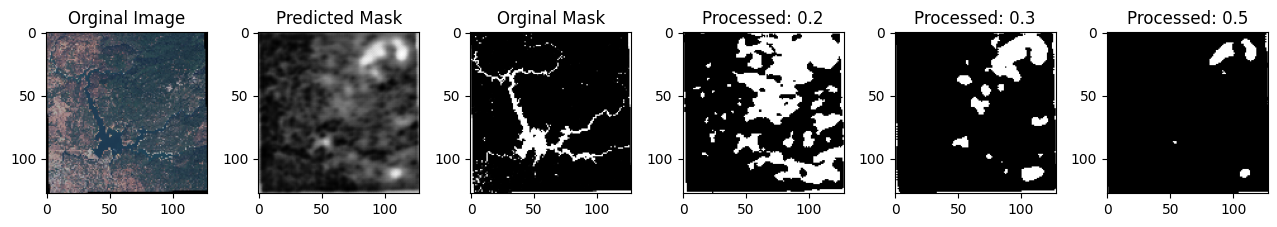

189/189 ━━━━━━━━━━━━━━━━━━━━ 35s 114ms/step - accuracy: 0.7372 - loss: 0.4428
Epoch 2/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8028 - loss: 0.251


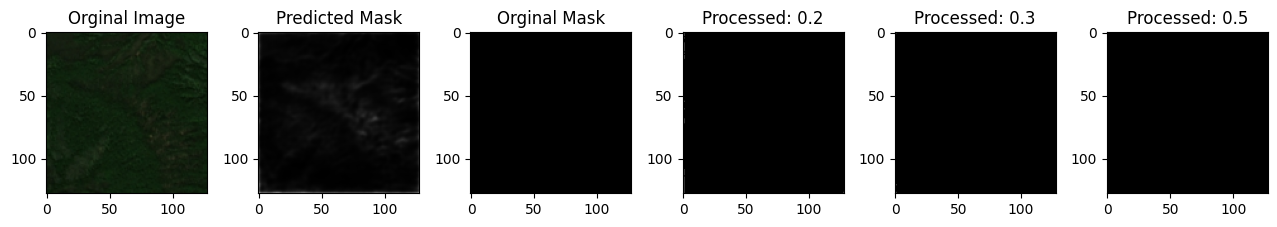

189/189 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.8028 - loss: 0.2518
Epoch 3/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8175 - loss: 0.215


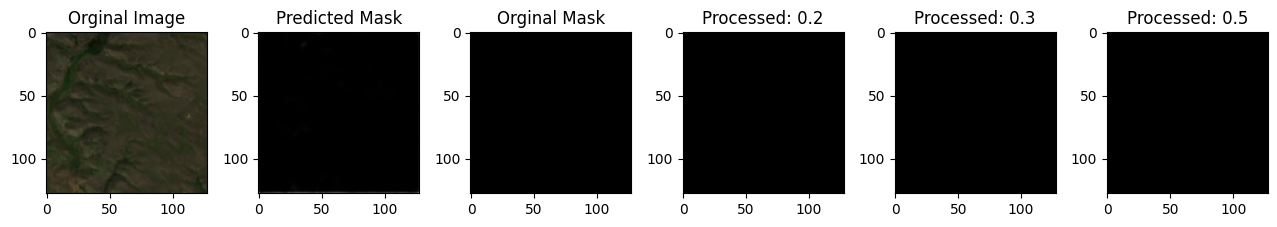

189/189 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.8175 - loss: 0.2152
Epoch 4/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8242 - loss: 0.195


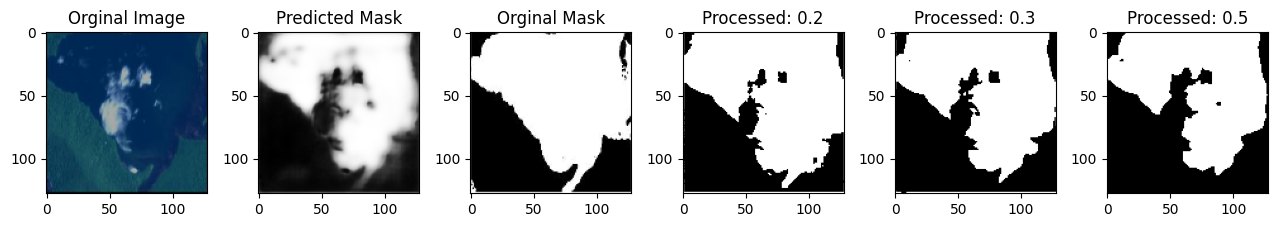

189/189 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.8243 - loss: 0.1949
Epoch 5/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8289 - loss: 0.17


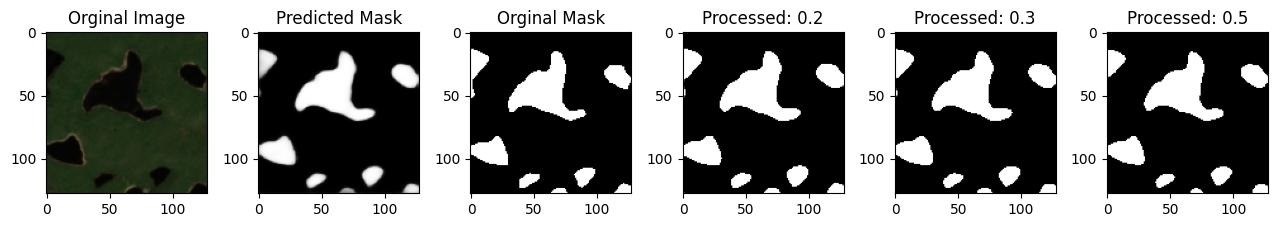

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8289 - loss: 0.1784
Epoch 6/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step/step - accuracy: 0.8360 - loss: 0.16


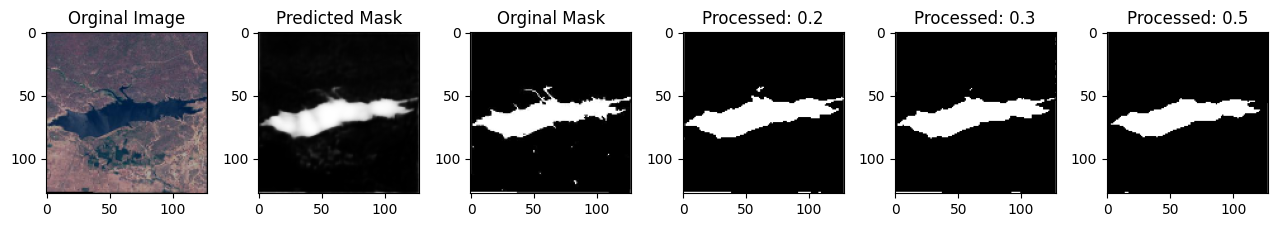

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8360 - loss: 0.1670
Epoch 7/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8356 - loss: 0.16


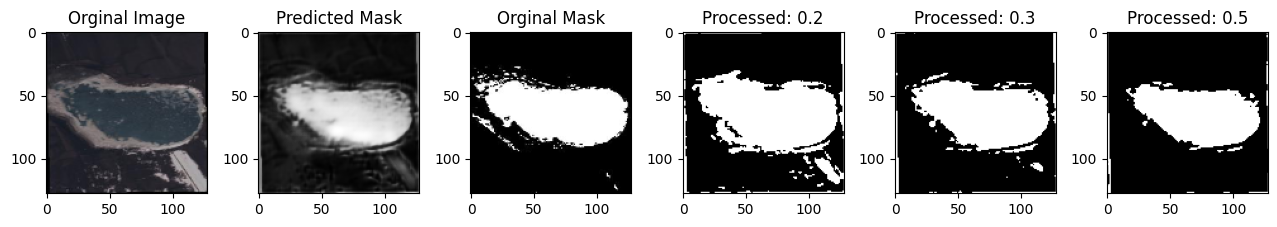

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8356 - loss: 0.1631
Epoch 8/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8379 - loss: 0.15


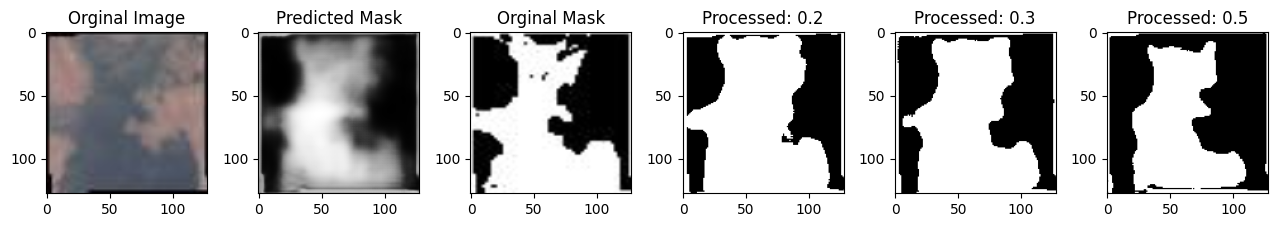

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8379 - loss: 0.1568
Epoch 9/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step/step - accuracy: 0.8401 - loss: 0.15


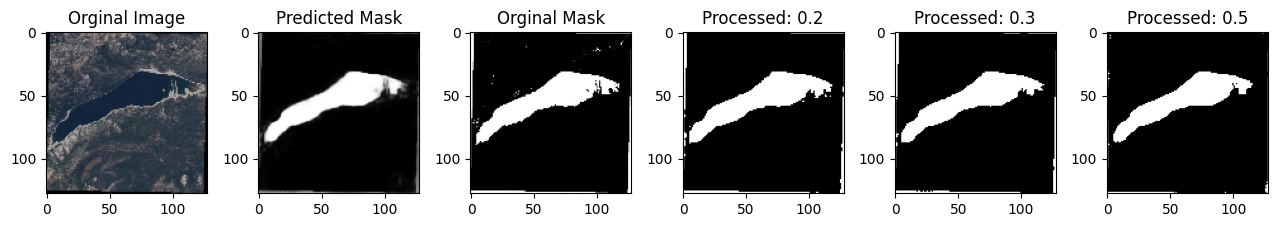

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8401 - loss: 0.1507
Epoch 10/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8416 - loss: 0.14


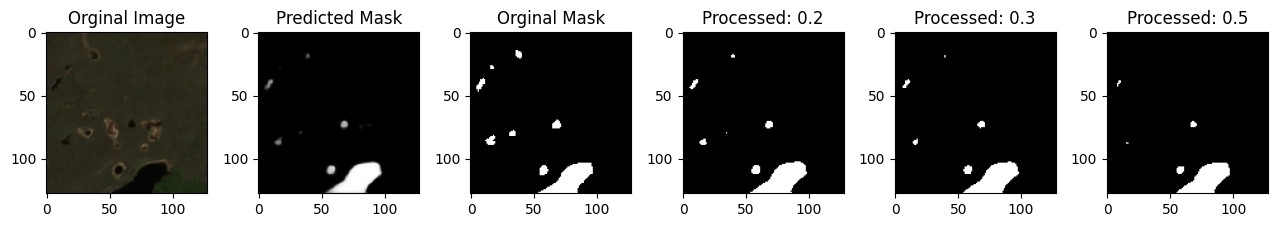

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8416 - loss: 0.1464
Epoch 11/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step/step - accuracy: 0.8388 - loss: 0.14


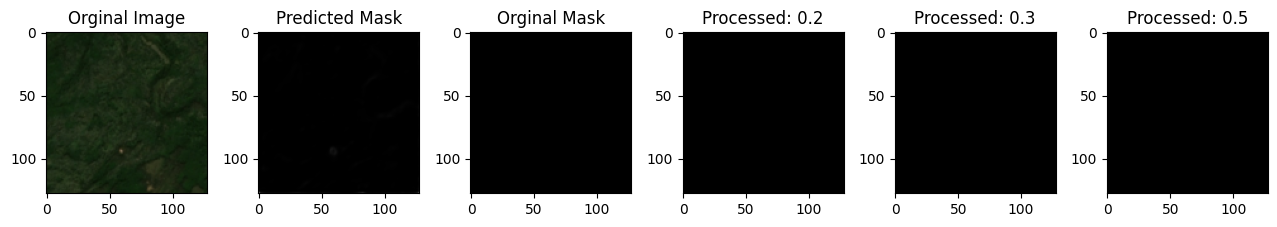

189/189 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.8388 - loss: 0.1478
Epoch 12/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8416 - loss: 0.141


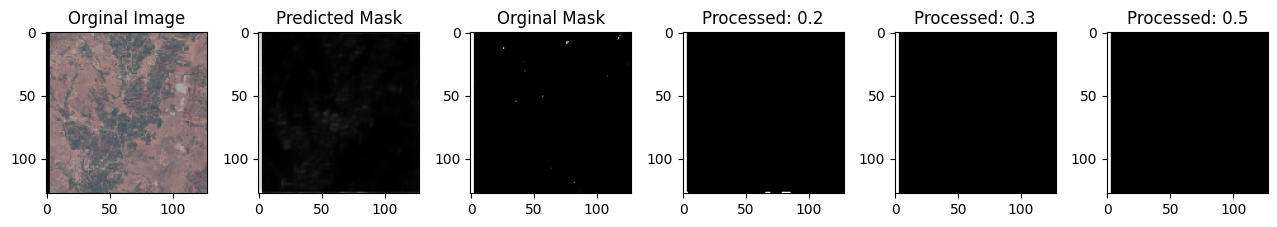

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8416 - loss: 0.1419
Epoch 13/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8410 - loss: 0.14


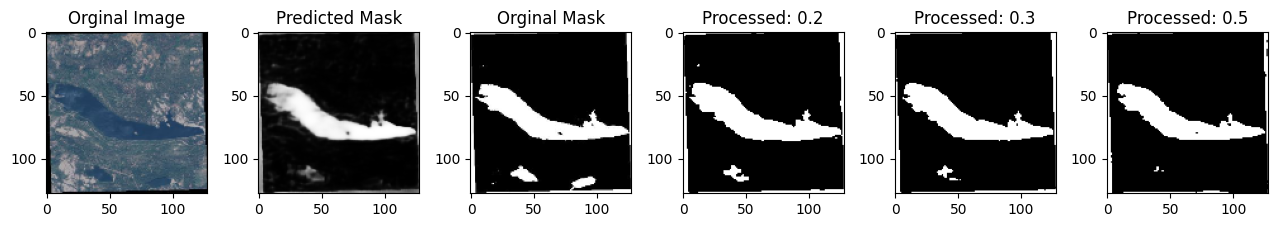

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8410 - loss: 0.1410
Epoch 14/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/stepstep - accuracy: 0.8450 - loss: 0.137


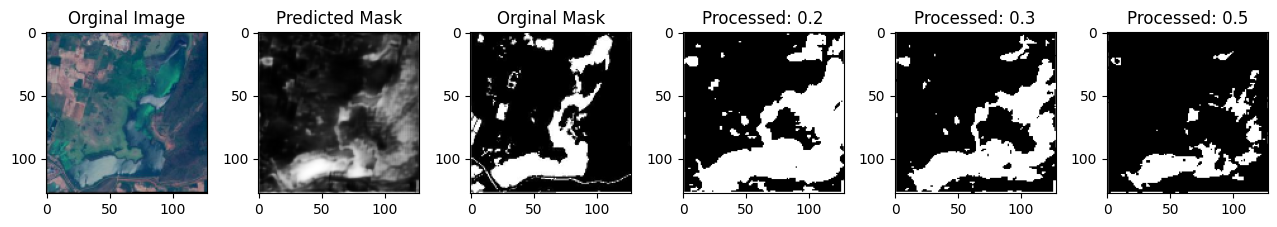

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8450 - loss: 0.1377
Epoch 15/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8452 - loss: 0.13


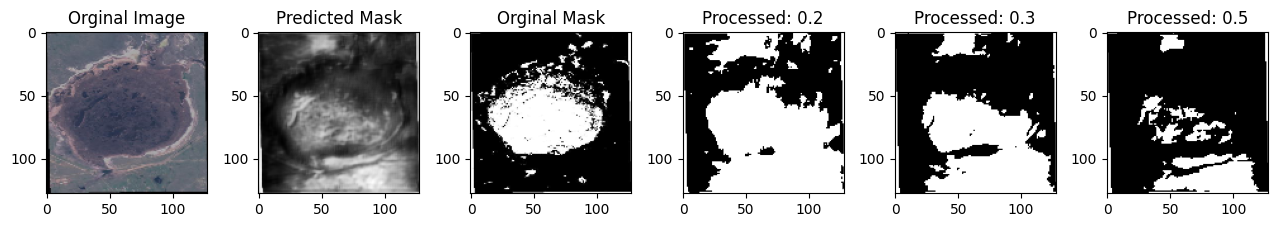

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8452 - loss: 0.1355
Epoch 16/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8416 - loss: 0.13


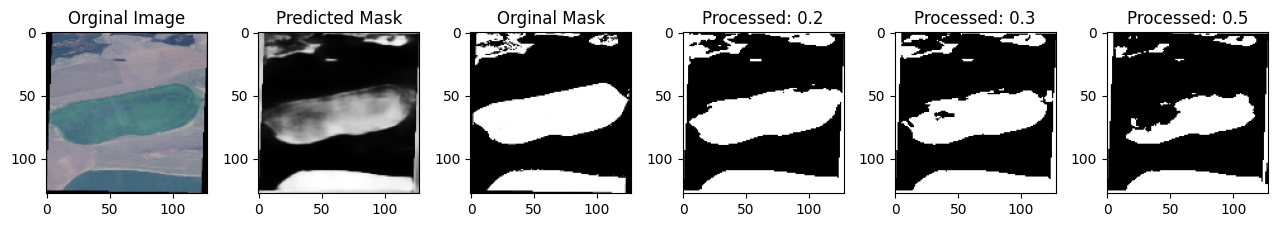

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8416 - loss: 0.1370
Epoch 17/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8441 - loss: 0.13


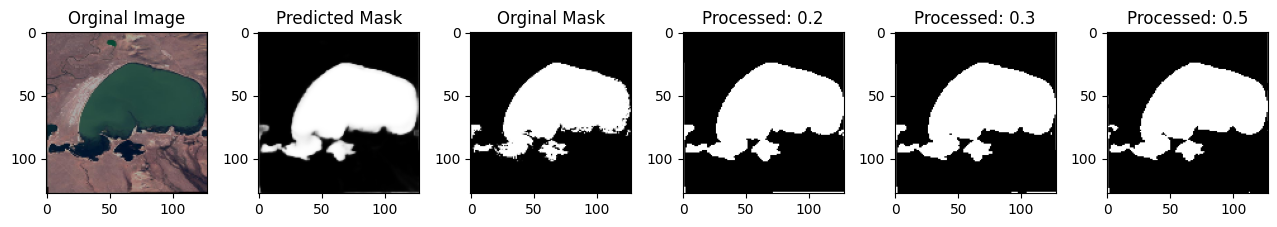

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8441 - loss: 0.1383
Epoch 18/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8447 - loss: 0.13


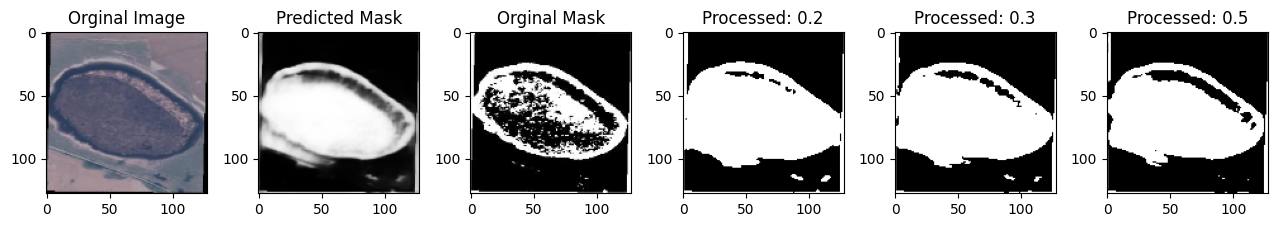

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8447 - loss: 0.1345
Epoch 19/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step/step - accuracy: 0.8454 - loss: 0.13


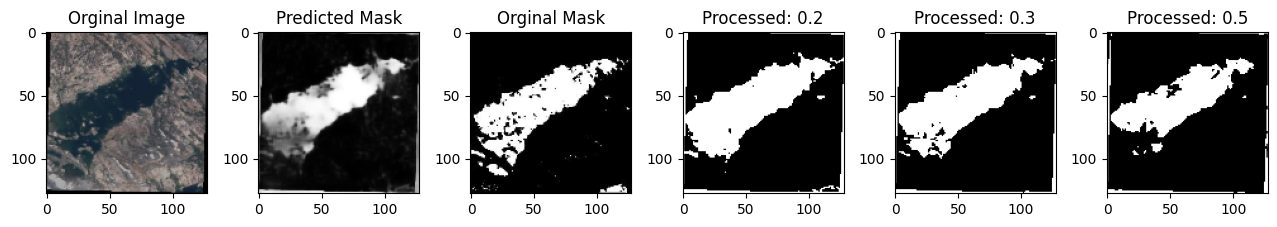

189/189 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.8454 - loss: 0.1304
Epoch 20/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8446 - loss: 0.13


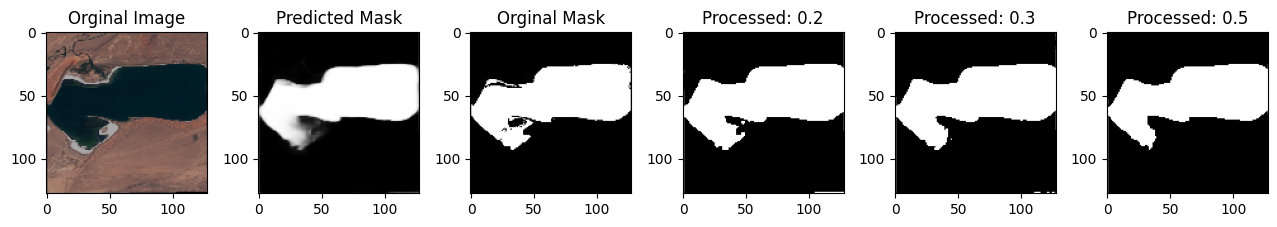

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8446 - loss: 0.1309
Epoch 21/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8468 - loss: 0.126


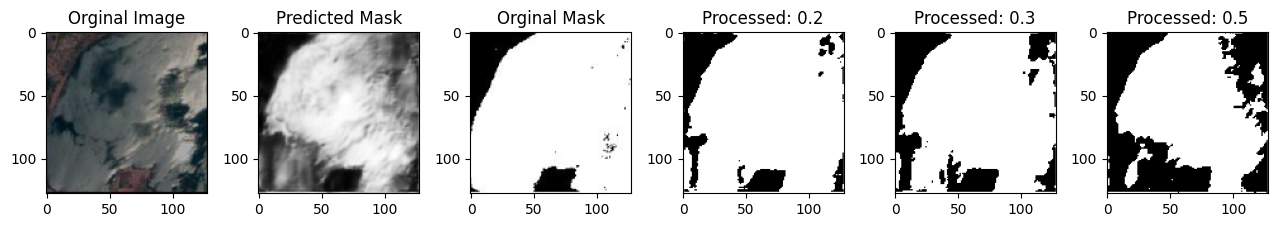

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8468 - loss: 0.1263
Epoch 22/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8455 - loss: 0.12


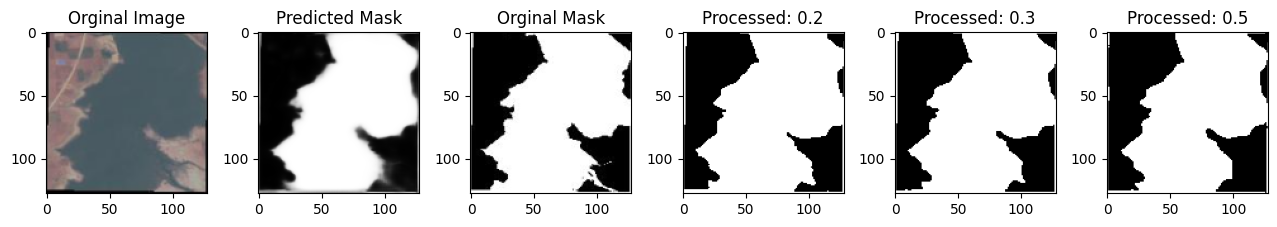

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8455 - loss: 0.1298
Epoch 23/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8446 - loss: 0.127


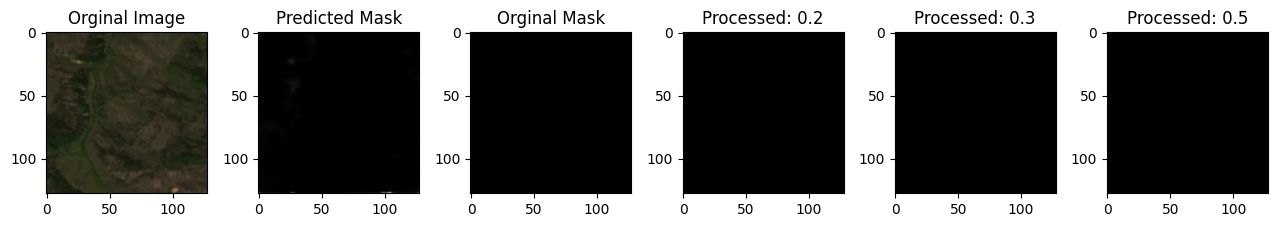

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8446 - loss: 0.1271
Epoch 24/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8479 - loss: 0.12


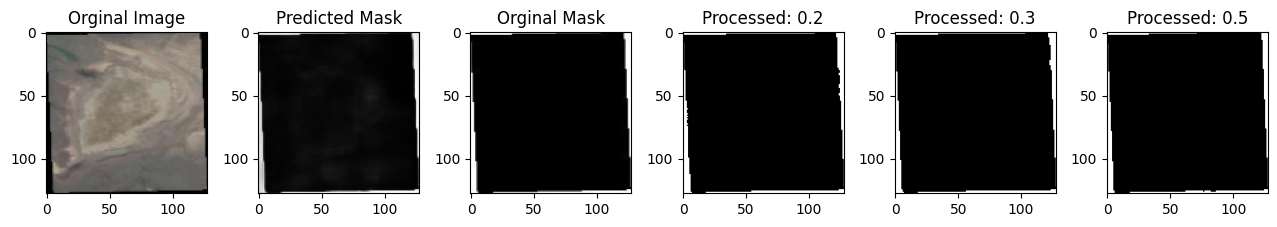

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8479 - loss: 0.1233
Epoch 25/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8494 - loss: 0.12


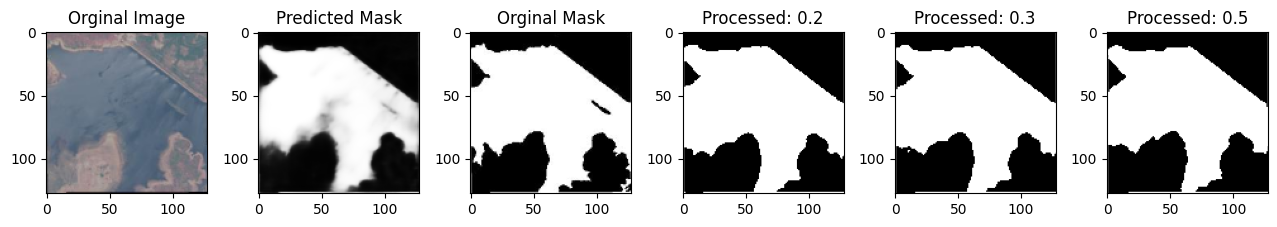

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8494 - loss: 0.1215
Epoch 26/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8443 - loss: 0.126


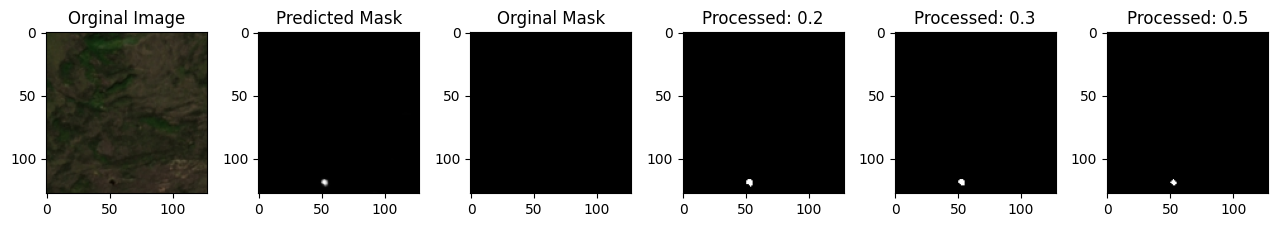

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.8443 - loss: 0.1264
Epoch 27/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.8476 - loss: 0.119


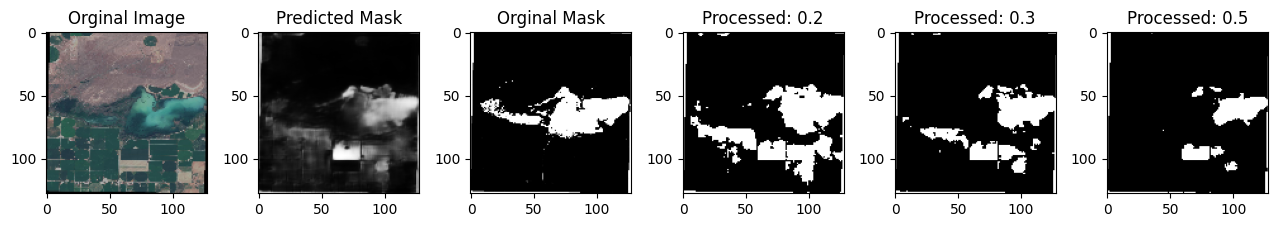

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8476 - loss: 0.1198
Epoch 28/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8514 - loss: 0.116


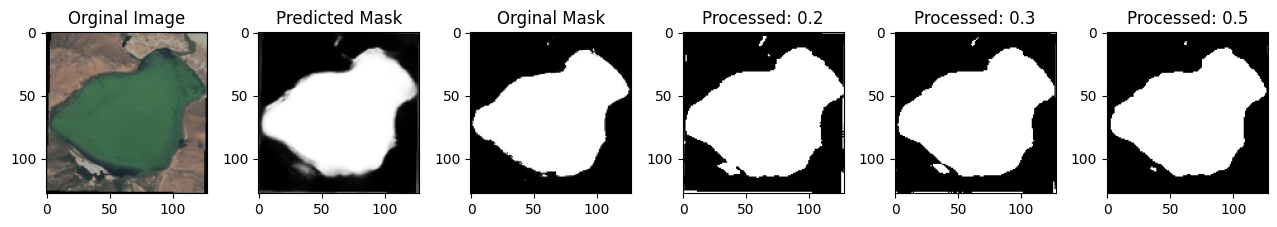

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8513 - loss: 0.1166
Epoch 29/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8459 - loss: 0.12


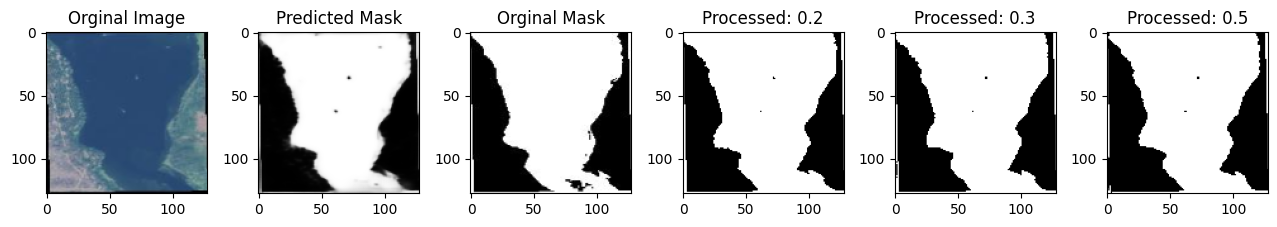

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8459 - loss: 0.1218
Epoch 30/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8491 - loss: 0.116


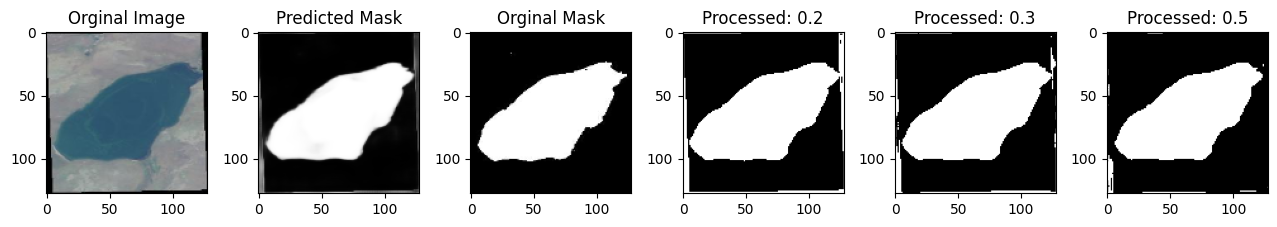

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8491 - loss: 0.1164
Epoch 31/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8481 - loss: 0.11


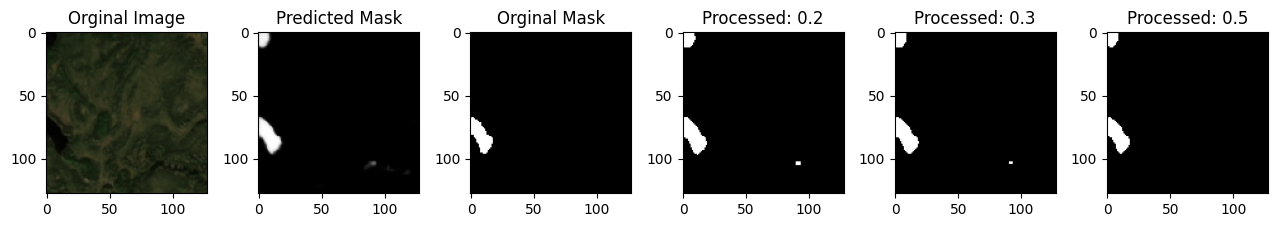

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8481 - loss: 0.1177
Epoch 32/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8475 - loss: 0.12


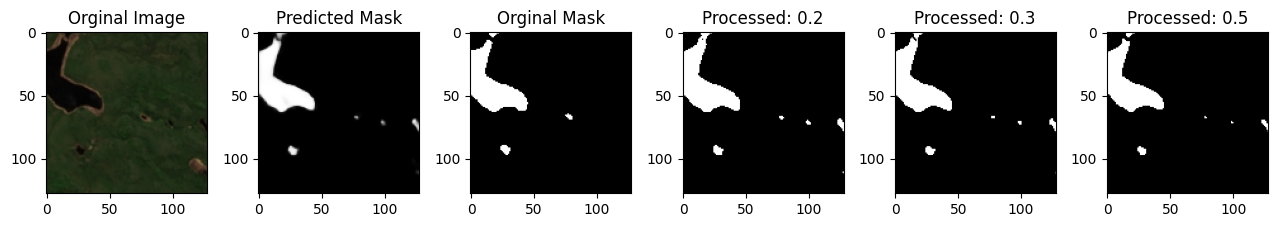

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8475 - loss: 0.1244
Epoch 33/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8478 - loss: 0.12


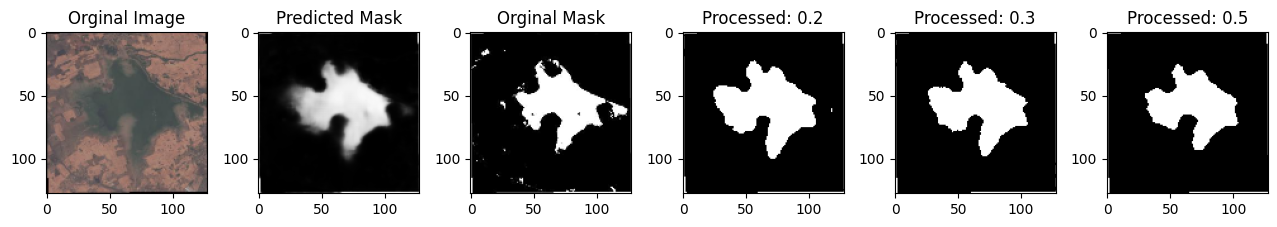

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8479 - loss: 0.1208
Epoch 34/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step/step - accuracy: 0.8498 - loss: 0.11


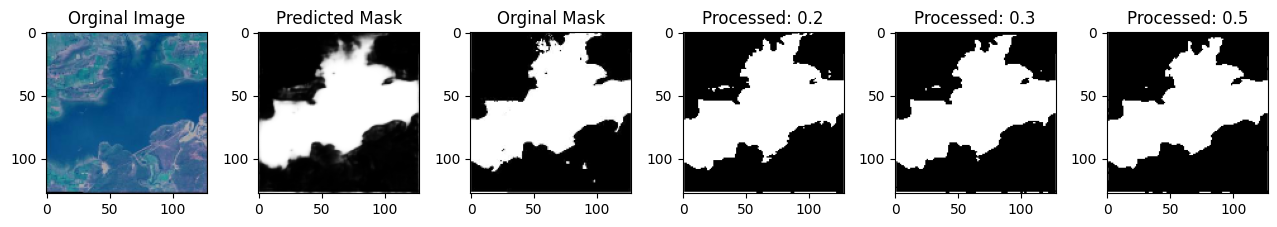

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8498 - loss: 0.1130
Epoch 35/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.8515 - loss: 0.111


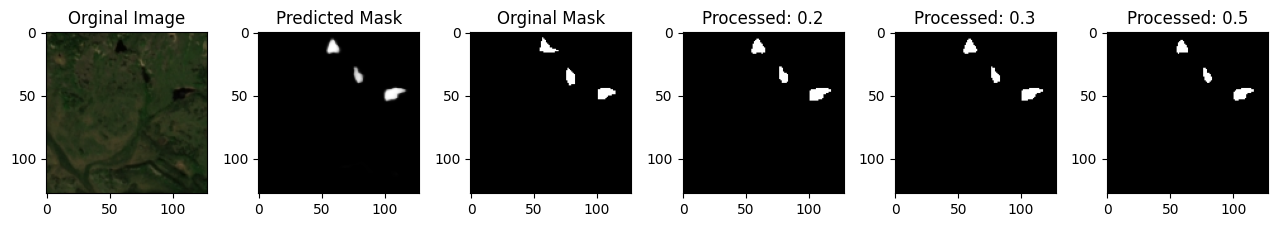

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8514 - loss: 0.1116
Epoch 36/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step/step - accuracy: 0.8489 - loss: 0.11


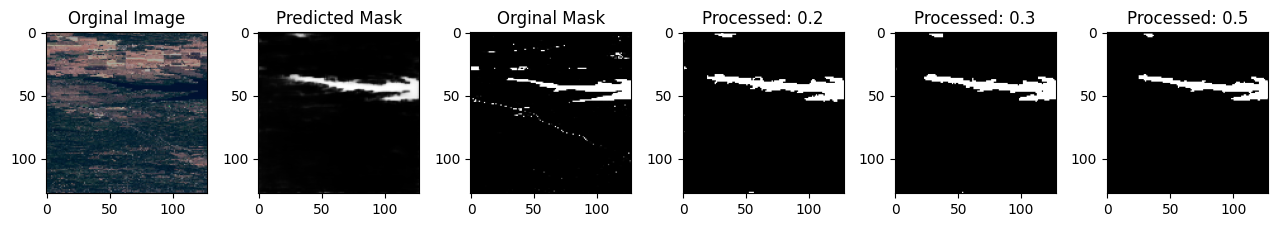

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8489 - loss: 0.1144
Epoch 37/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.8512 - loss: 0.111


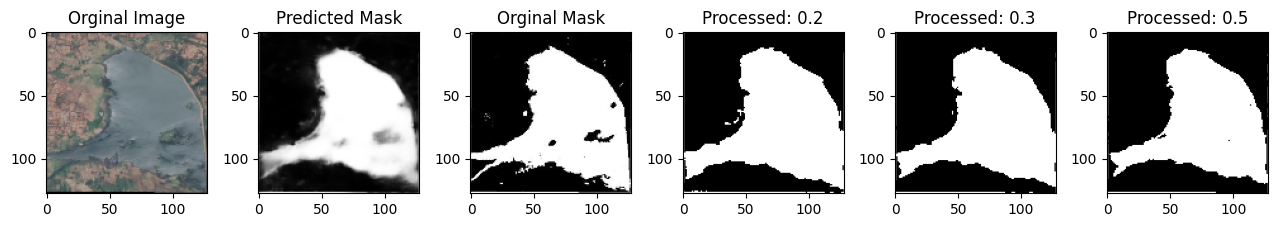

189/189 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.8512 - loss: 0.1115
Epoch 38/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.8510 - loss: 0.111


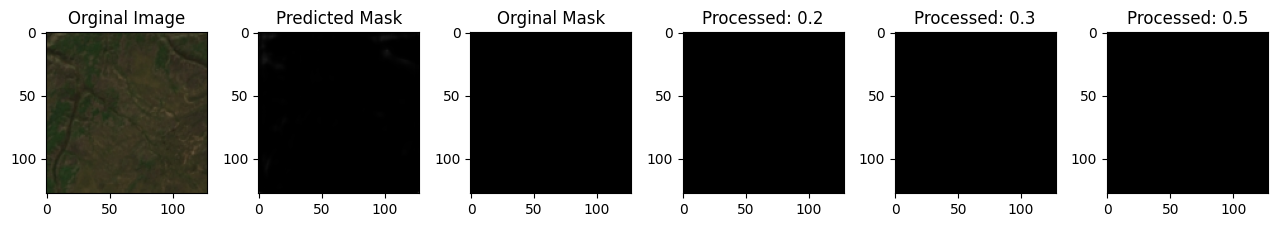

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8510 - loss: 0.1116
Epoch 39/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step/step - accuracy: 0.8522 - loss: 0.10


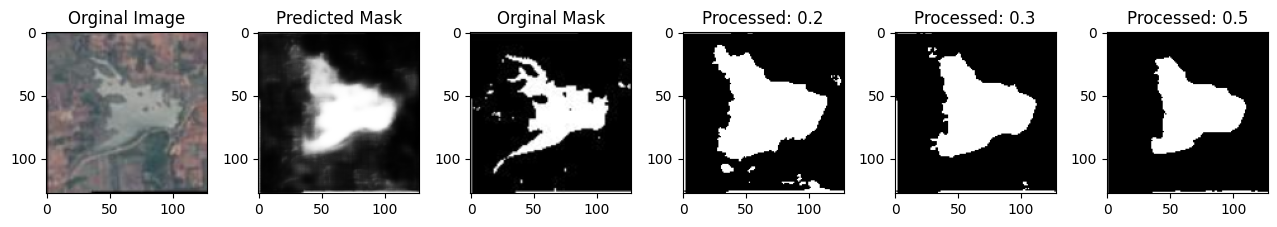

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8522 - loss: 0.1079
Epoch 40/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8488 - loss: 0.11


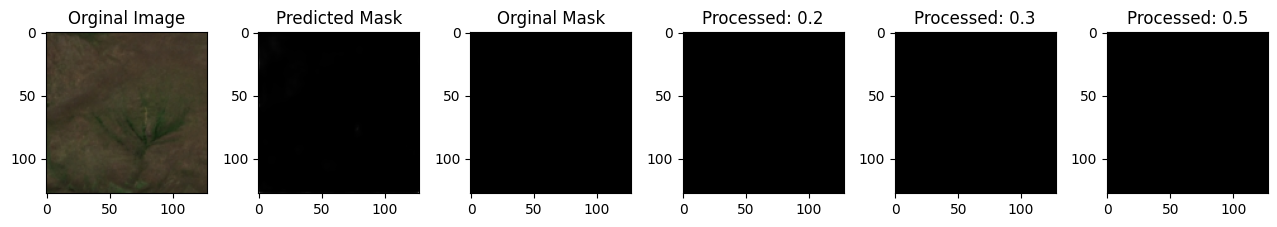

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8488 - loss: 0.1107
Epoch 41/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8487 - loss: 0.11


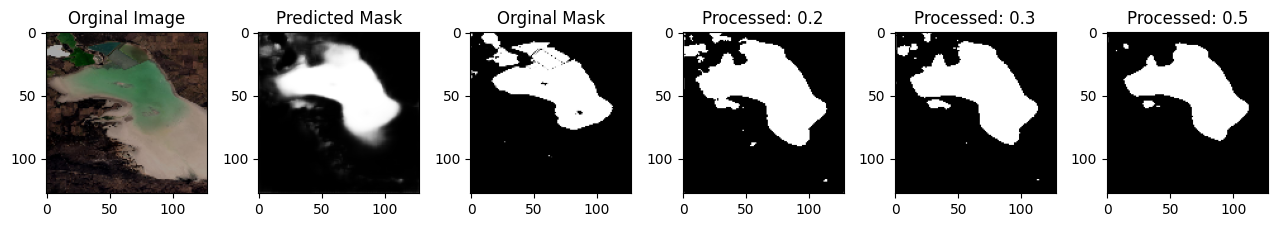

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8487 - loss: 0.1139
Epoch 42/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step/step - accuracy: 0.8484 - loss: 0.11


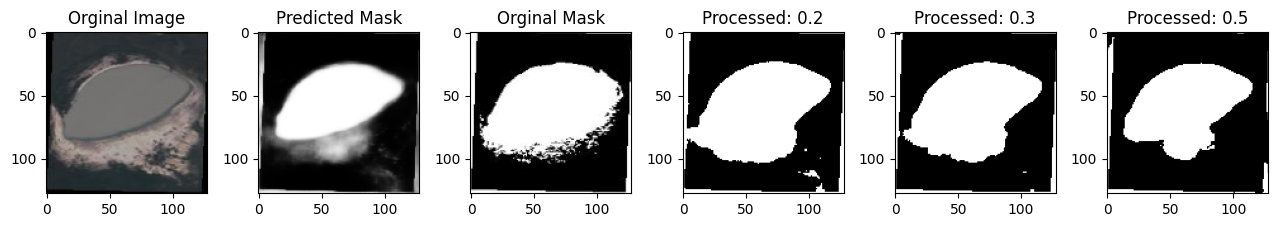

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8484 - loss: 0.1100
Epoch 43/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8504 - loss: 0.10


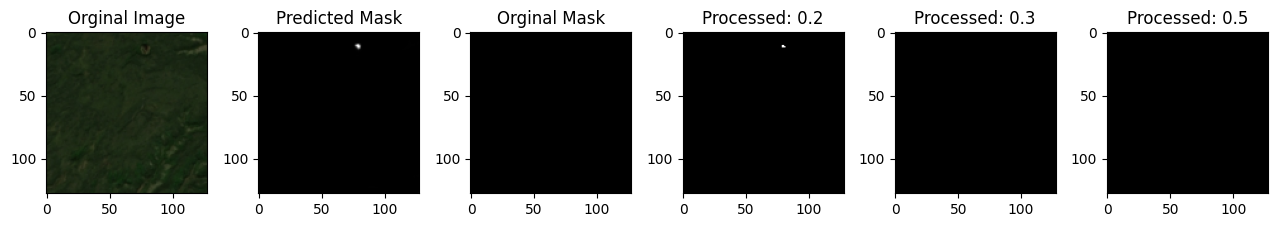

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8504 - loss: 0.1091
Epoch 44/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8528 - loss: 0.10


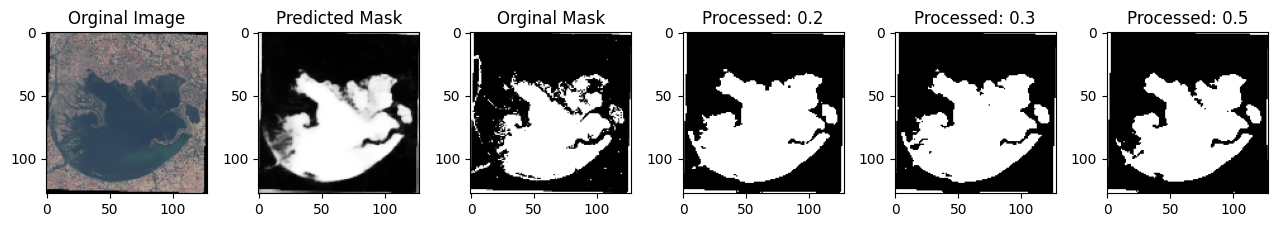

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8528 - loss: 0.1069
Epoch 45/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8498 - loss: 0.10


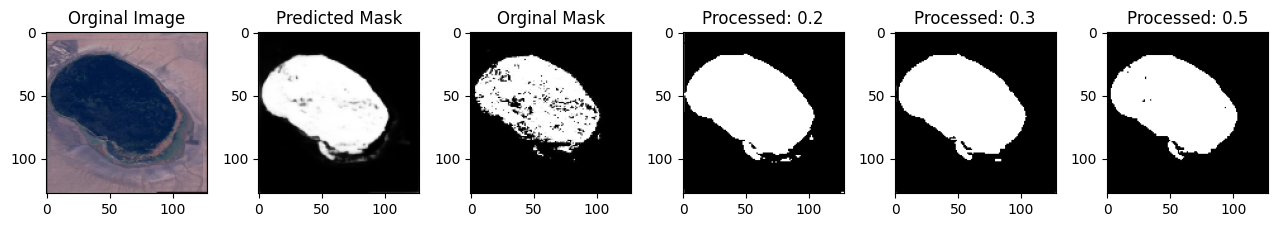

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8498 - loss: 0.1095
Epoch 46/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8529 - loss: 0.10


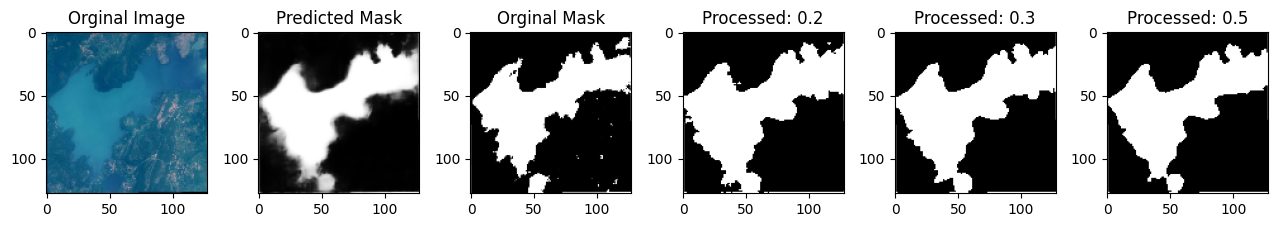

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8529 - loss: 0.1037
Epoch 47/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8548 - loss: 0.10


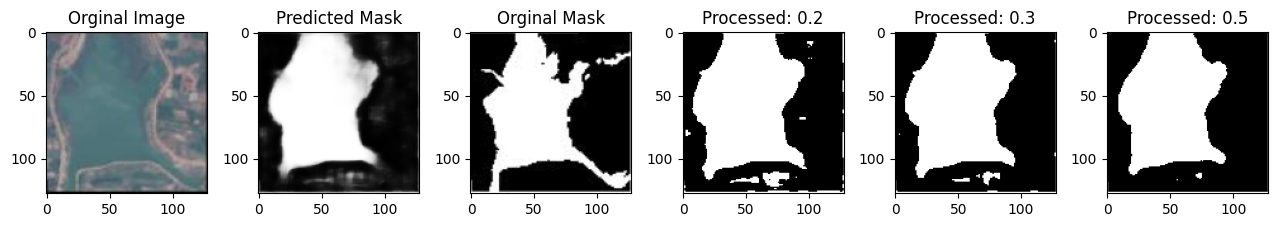

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8548 - loss: 0.1009
Epoch 48/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8525 - loss: 0.10


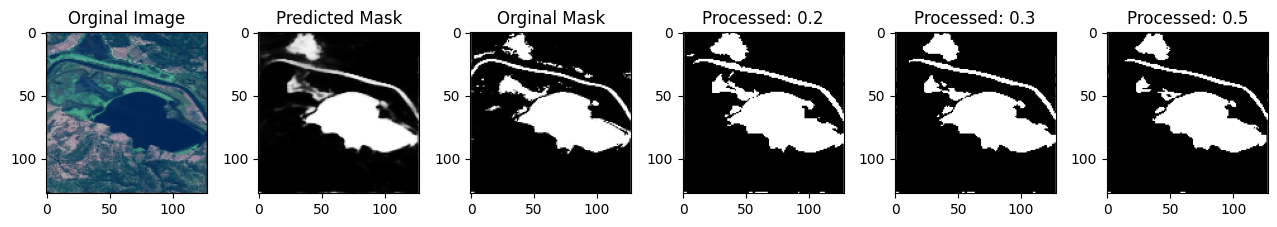

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8525 - loss: 0.1046
Epoch 49/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8553 - loss: 0.101


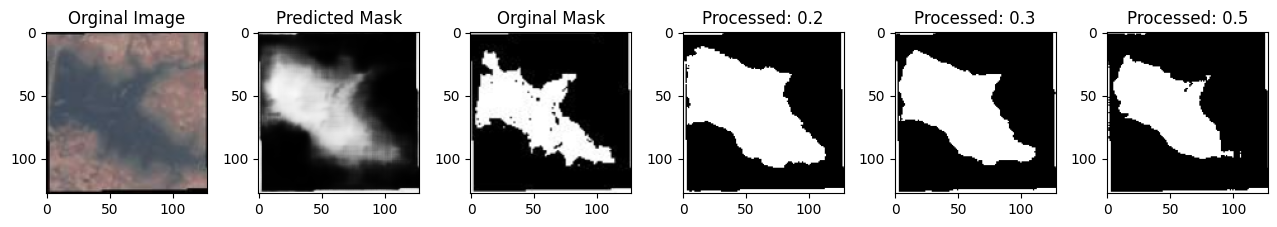

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8553 - loss: 0.1019
Epoch 50/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step/step - accuracy: 0.8510 - loss: 0.10


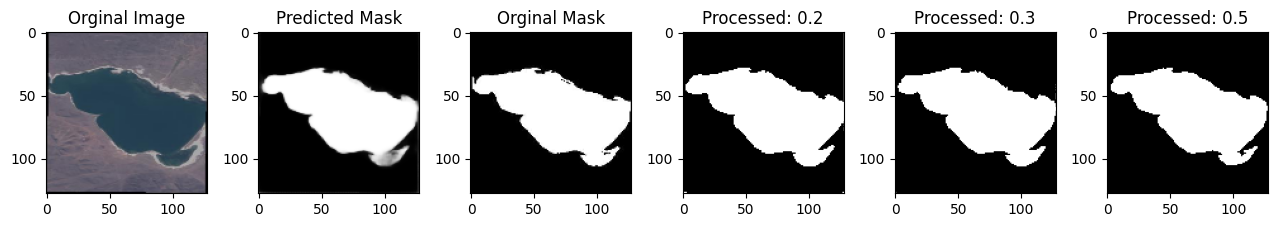

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8510 - loss: 0.1027
Epoch 51/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8544 - loss: 0.10


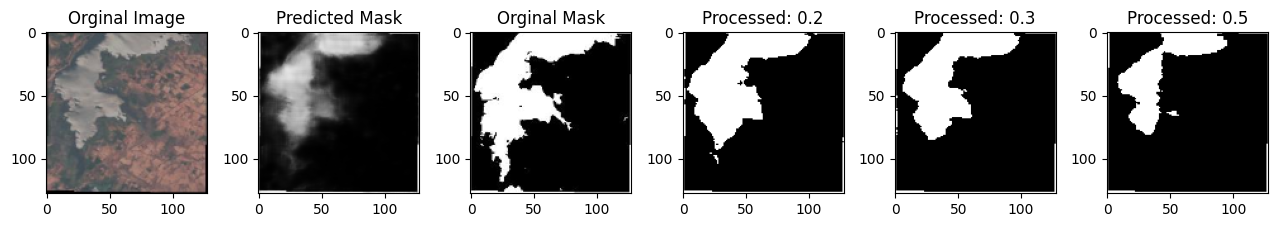

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8544 - loss: 0.1005
Epoch 52/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8505 - loss: 0.11


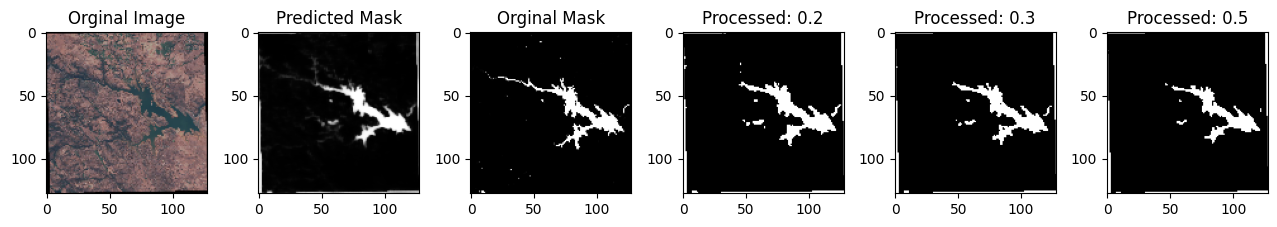

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8505 - loss: 0.1160
Epoch 53/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8533 - loss: 0.10


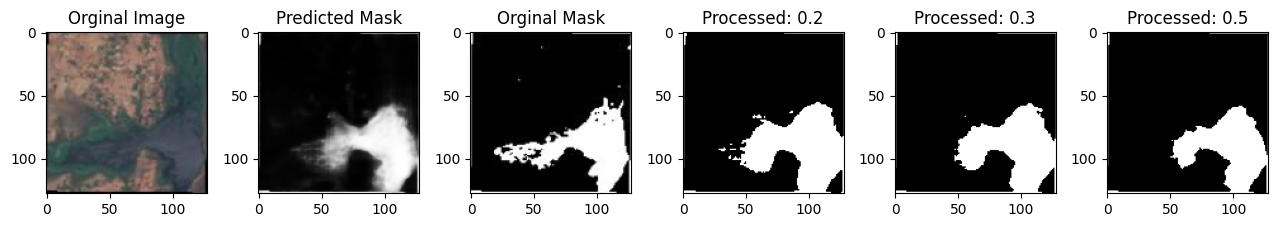

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8533 - loss: 0.1020
Epoch 54/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8549 - loss: 0.09


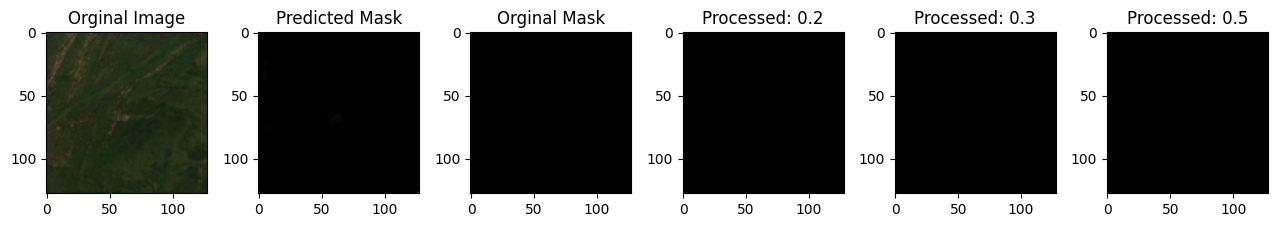

189/189 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.8549 - loss: 0.0979
Epoch 55/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/stepstep - accuracy: 0.8522 - loss: 0.101


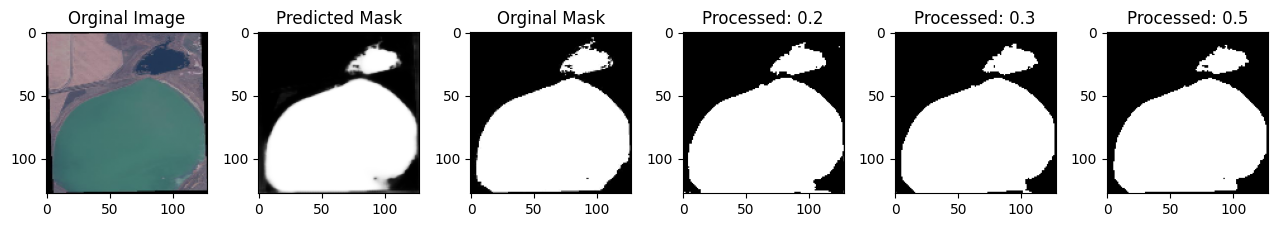

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8522 - loss: 0.1015
Epoch 56/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8559 - loss: 0.097


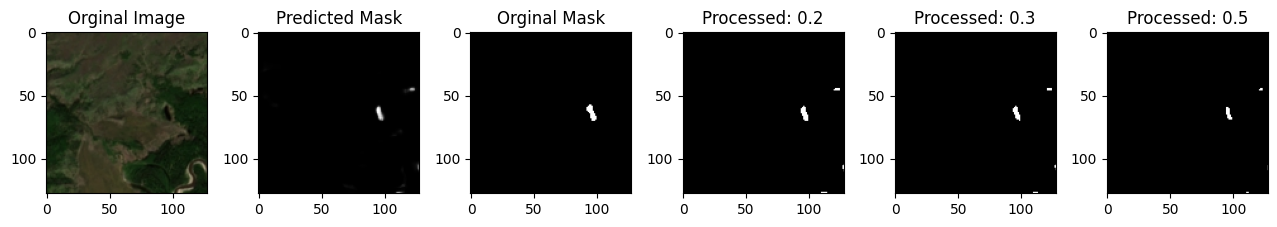

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8559 - loss: 0.0973
Epoch 57/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8536 - loss: 0.102


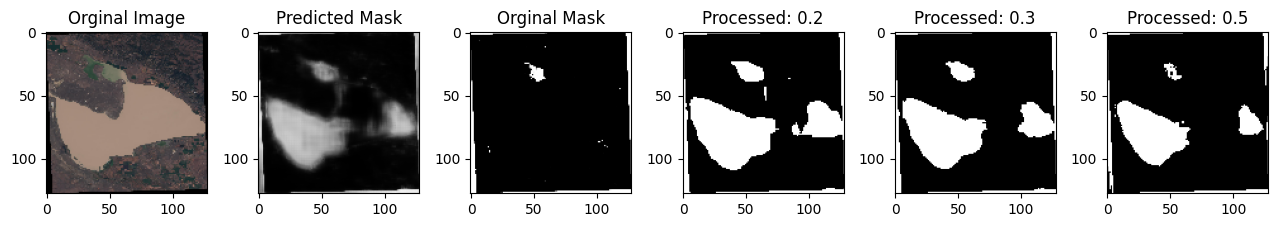

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8536 - loss: 0.1024
Epoch 58/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step/step - accuracy: 0.8520 - loss: 0.10


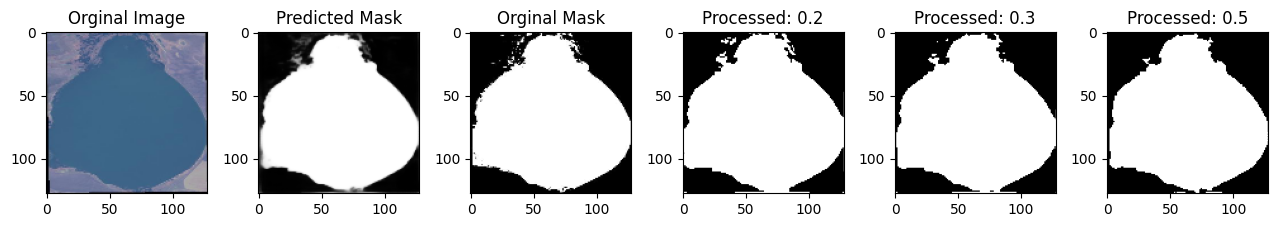

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8520 - loss: 0.1078
Epoch 59/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8549 - loss: 0.09


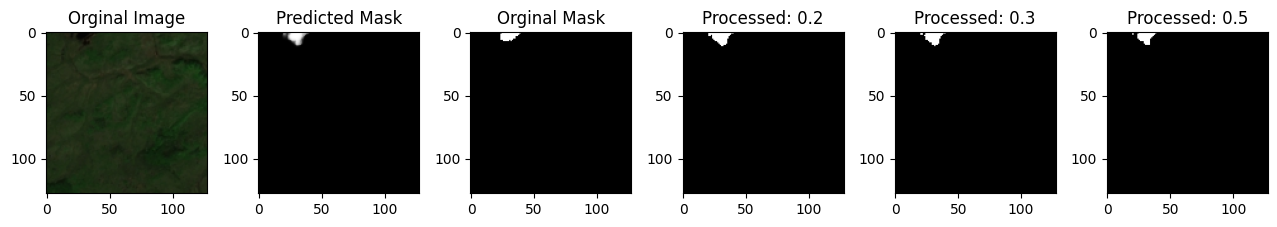

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8549 - loss: 0.0993
Epoch 60/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8550 - loss: 0.09


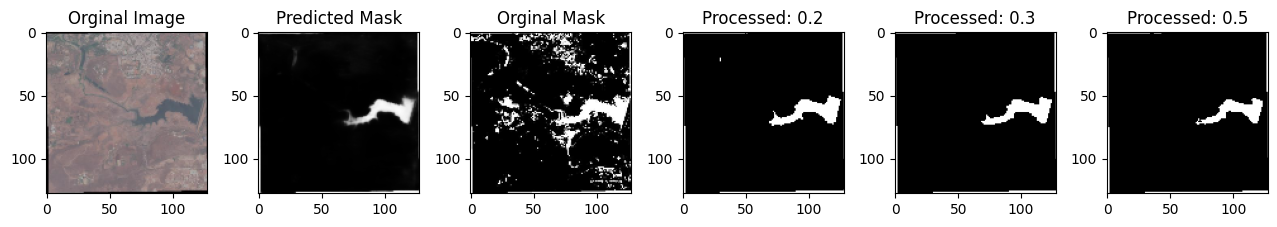

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8550 - loss: 0.0982
Epoch 61/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8521 - loss: 0.09


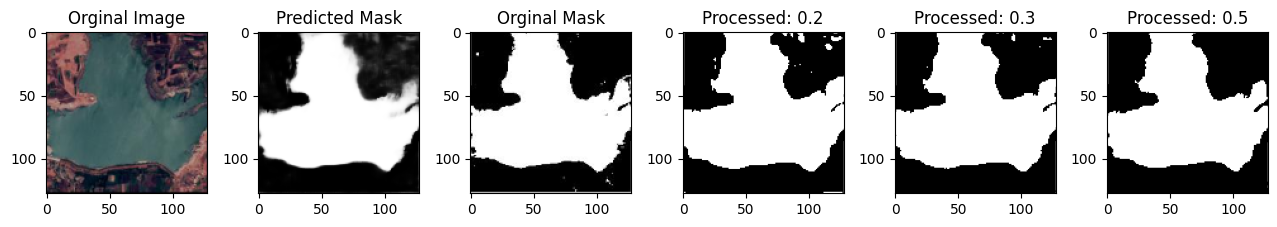

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8521 - loss: 0.0998
Epoch 62/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.8543 - loss: 0.098


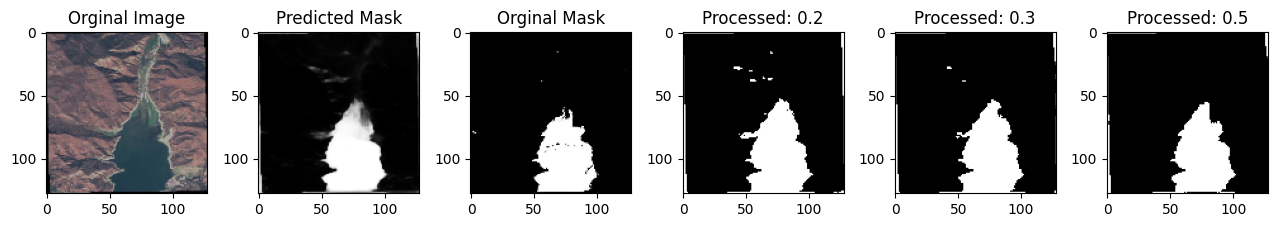

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8543 - loss: 0.0985
Epoch 63/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8548 - loss: 0.09


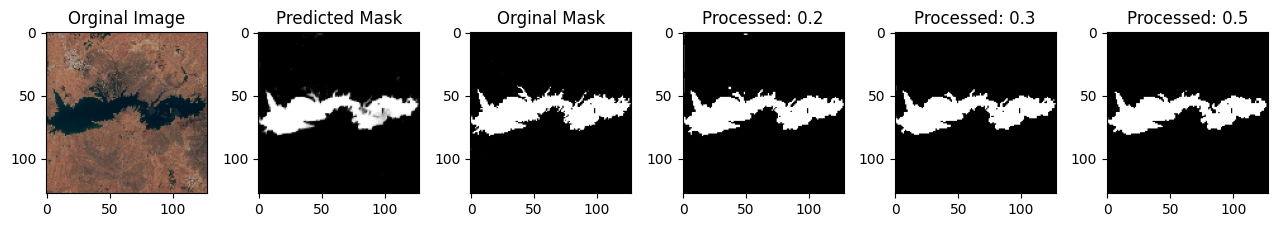

189/189 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.8548 - loss: 0.0980
Epoch 64/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8558 - loss: 0.09


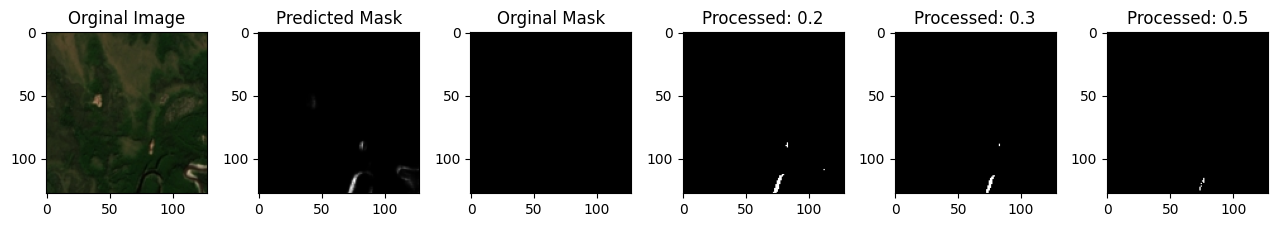

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8558 - loss: 0.0964
Epoch 65/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8523 - loss: 0.09


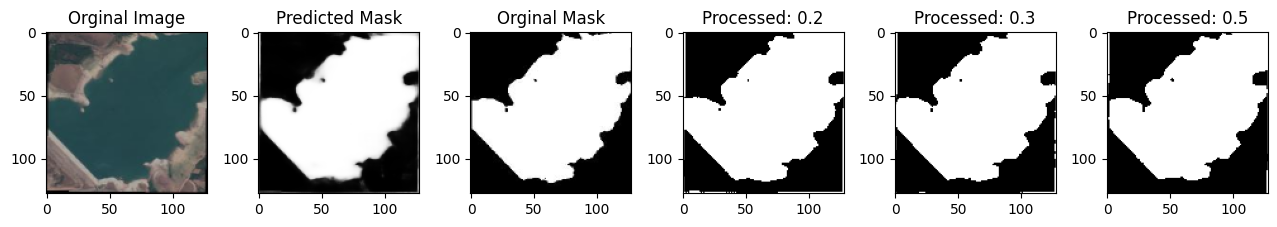

189/189 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.8523 - loss: 0.0962
Epoch 66/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8529 - loss: 0.09


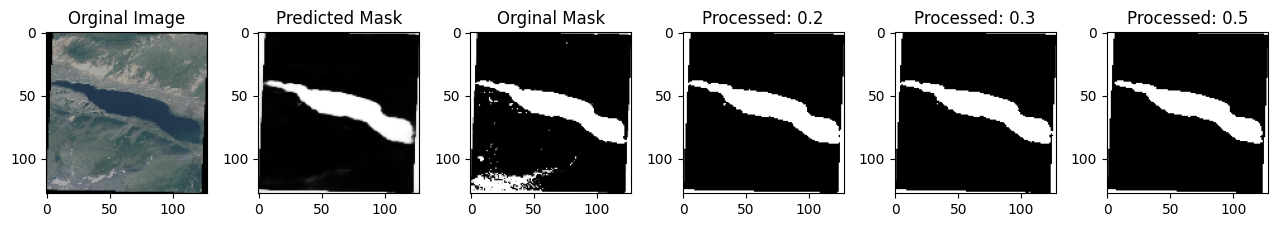

189/189 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.8529 - loss: 0.0954
Epoch 67/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8533 - loss: 0.10


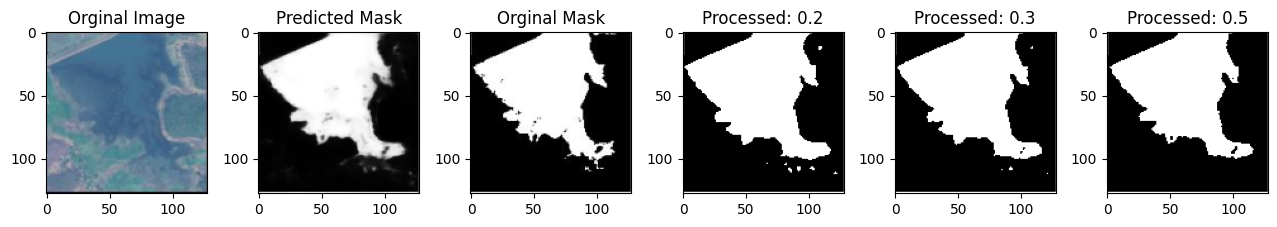

189/189 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.8532 - loss: 0.1051
Epoch 68/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8542 - loss: 0.09


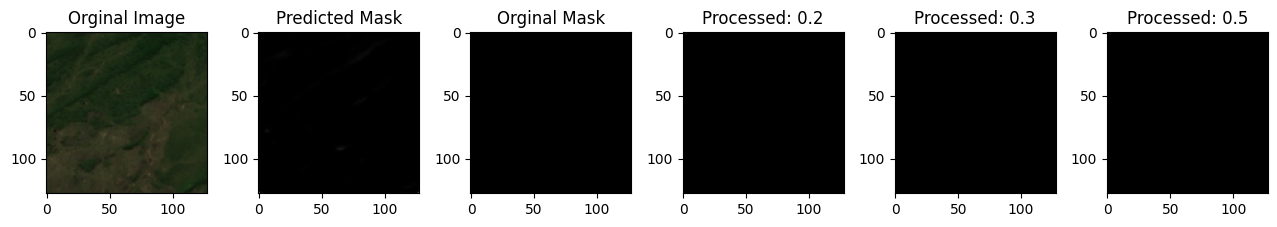

189/189 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.8542 - loss: 0.0982
Epoch 69/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8553 - loss: 0.09


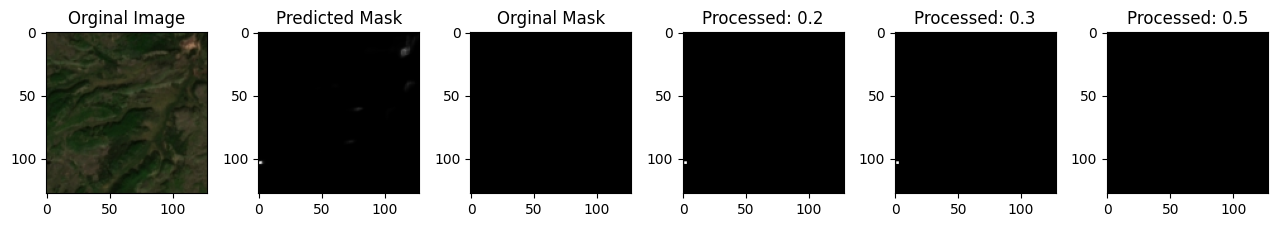

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8553 - loss: 0.0969
Epoch 70/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8536 - loss: 0.095


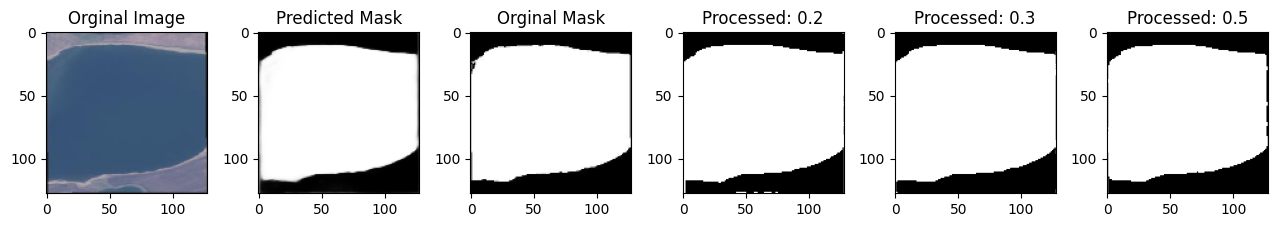

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8536 - loss: 0.0949
Epoch 71/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8549 - loss: 0.09


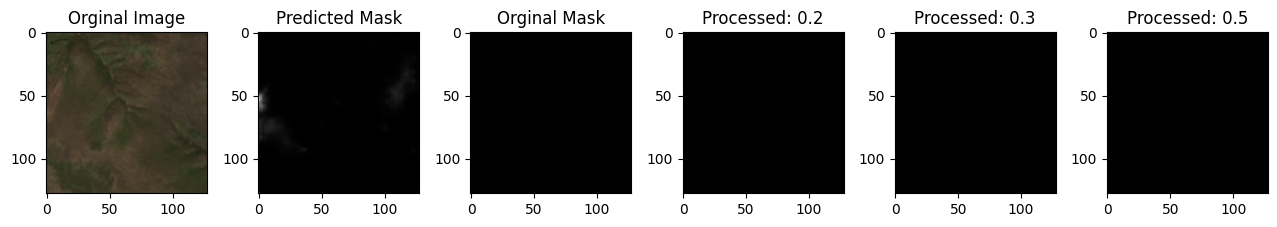

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8549 - loss: 0.0922
Epoch 72/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8552 - loss: 0.09


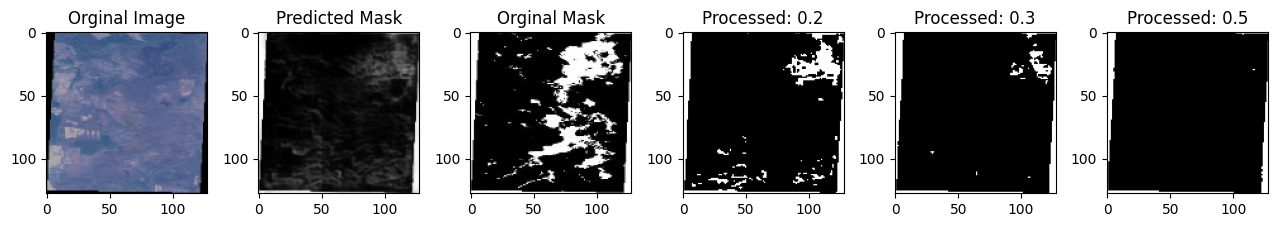

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8552 - loss: 0.0944
Epoch 73/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8539 - loss: 0.09


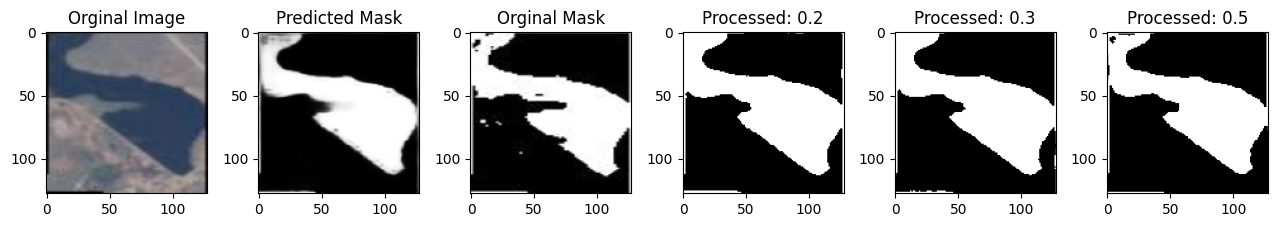

189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8539 - loss: 0.0951
Epoch 74/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8564 - loss: 0.091


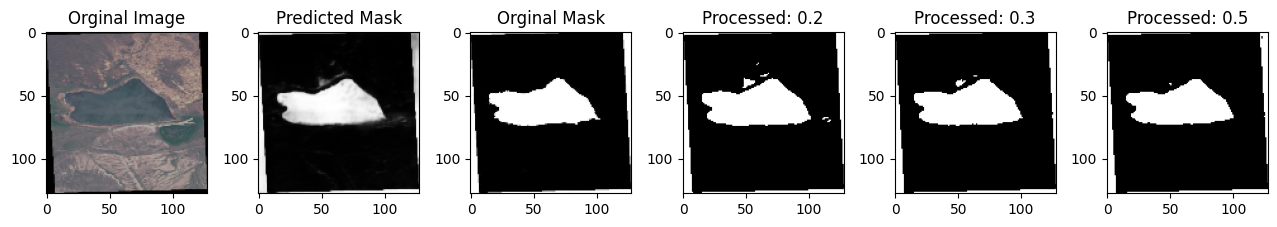

189/189 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.8564 - loss: 0.0916
Epoch 75/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8565 - loss: 0.09


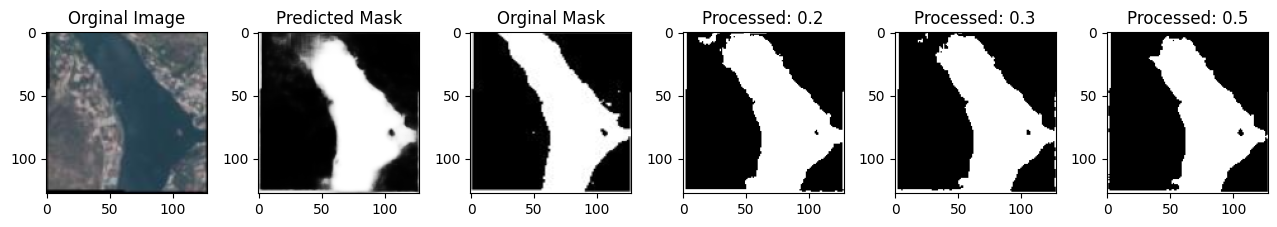

189/189 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.8565 - loss: 0.0929


In [13]:
epochs = 75
batch_size = 64

history = model.fit(
    augmented_images_train,  # Use augmented data instead of original
    augmented_masks_train,   # Use augmented masks
    epochs=epochs,
    callbacks=[ShowProgress()],
    batch_size=batch_size,
    shuffle=True             # Make sure to shuffle
)

In [14]:
from datetime import datetime

# Get the current date and time
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Save the model with the current date and time in the filename
model.save(f"../models/{current_time}.keras")